# Predicting game popularity with iOS App Store data
Vincent Sayseng (last update: January 3, 2020)

## Table of contents

1. [Motivation](#motivation)
2. [Creating a regression model to predict popularity](#createmodel)
    1. [Data exploration](#dataexplore)
    2. [Data cleaning](#dataclean)
    3. [Generating training and testing sets](#testtrainsets)
    4. [Processing pipeline](#pipeline)
    5. [Model training and selection](#modelselect)
3. [Interpreting the regression model results](#interpretresults)
    1. [Model evaluation](#evalreg)
    2. [Feature importance](#featimportance)
    3. [Important numerical features](#numfeat)
    4. [Important categorical features](#catfeat)
4. [Business strategy recommendations](#business)
    1. [Recommendations](#recs)
    2. [Model limitations](#limitations)
    3. [Potential future improvements](#future)

## Motivation <a name='motivation'></a>

The iOS App Store contains profiles for each mobile game available on the platform (https://apps.apple.com/us/genre/ios-games/id6014). Profiles include features such as genre, review scores, languages available, and age rating. 

The purpose of this project is to determine whether any of these features is correlated with a game's popularity. Understanding the importance of each feature can inform Game Revenant's business strategy to improve sales of its mobile game, **Where Shadows Slumber (WSS)**, available here: https://apps.apple.com/us/app/where-shadows-slumber/id1221749074. 


## Creating a regression model to predict popularity <a name='createmodel'></a>

A regression model will be designed to predict a game's popularity based on features listed in the App Store game profiles. **Since the App Store does not report the number of downloads directly, the number of review ratings a game has received will be used as a surrogate target metric**. 

### Data exploration <a name='dataexplore'></a>

Profiles of games on the App Store were scraped using the package Scrapy. Game profiles were stored in a SQLite database, in a table named after the genre section they were scrapped from. Note that a game can appear in multiple genre sections. The web scraping code may be found in another repository in my GitHub, https://github.com/vin-say/web-scraping/tree/master/iosgames.

In [1]:
# import basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sa

# Move to main directory of the Customer-Segmentation project
%cd ..

C:\Users\Vincent\Game-Revenant\Where-Shadows-Slumber\App-Store-Analysis


The scraped data is loaded from the database. The tables (one for each game genre) are merged into one. 

In [2]:
from pathlib import Path

# Pull interim data from SQLite DB

DB_NAME = 'app-store'
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
query = '''
        SELECT *, 'action' AS genre FROM iosaction UNION
        SELECT *, 'adventure' FROM iosadventure UNION
        SELECT *, 'board' FROM iosboard UNION
        SELECT *, 'card' FROM ioscard UNION 
        SELECT *, 'casino' FROM ioscasino UNION
        SELECT *, 'casual' FROM ioscasual UNION
        SELECT *, 'family' FROM iosfamily UNION
        SELECT *, 'music' FROM iosmusic UNION
        SELECT *, 'puzzle' FROM iospuzzle UNION
        SELECT *, 'racing' FROM iosracing UNION
        SELECT *, 'rpg' FROM iosrpg UNION
        SELECT *, 'simulation' FROM iossimulation UNION
        SELECT *, 'sports' FROM iossports UNION 
        SELECT *, 'strategy'FROM iosstrategy UNION 
        SELECT *, 'trivia' FROM iostrivia UNION
        SELECT *, 'word' FROM iosword
        '''
apps = pd.read_sql_query(query, e)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380969 entries, 0 to 380968
Data columns (total 20 columns):
age          380969 non-null object
age_copy     380969 non-null object
author       380690 non-null object
category     380969 non-null object
compat       380969 non-null object
desc         380969 non-null object
editor       1384 non-null object
iap          148075 non-null object
lang         380969 non-null object
list_rank    11006 non-null object
nrating      234417 non-null object
price        380896 non-null object
score        234417 non-null object
seller       380969 non-null object
size         380969 non-null object
stars        234417 non-null object
subtitle     121114 non-null object
support      380969 non-null object
title        380969 non-null object
genre        380969 non-null object
dtypes: object(20)
memory usage: 58.1+ MB


Loading the data, it is apparent that the data needs be cleaned. Each field is populated by strings, and not all entries were available for each game profile. A sample of the raw data is shown below. 

In [3]:
apps.head()

,age,age_copy,author,category,compat,desc,editor,iap,lang,list_rank,nrating,price,score,seller,size,stars,subtitle,support,title,genre
0,12+,"""Media5 Interactive"" LLC,479.4 MB,,,,,,,Rated ...","""Media5 Interactive"" LLC",Games,Requires iOS 8.0 or later. Compatible with iPh...,The game allows you to develop and perfect a s...,None,Offers In-App Purchases,English,None,1 Rating,Free,2.0,"""Media5 Interactive"" LLC",479.4 MB,"width: 0%;,width: 0%;,width: 0%;,width: 100%;,...",None,"Game Center,Family Sharing",Sniper Shooting Champion,simulation
1,12+,"""Media5 Interactive"" LLC,479.4 MB,,,,,,,Rated ...","""Media5 Interactive"" LLC",Games,Requires iOS 8.0 or later. Compatible with iPh...,The game allows you to develop and perfect a s...,None,Offers In-App Purchases,English,None,1 Rating,Free,2.0,"""Media5 Interactive"" LLC",479.4 MB,"width: 0%;,width: 0%;,width: 0%;,width: 100%;,...",None,"Game Center,Family Sharing",Sniper Shooting Champion,sports
2,12+,"""Media5 Interactive"" LLC,78.2 MB,,,,,,,Rated 1...","""Media5 Interactive"" LLC",Games,Requires iOS 6.0 or later. Compatible with iPh...,The most stunning flail fighting game ever - R...,None,Offers In-App Purchases,English,None,None,Free,None,"""Media5 Interactive"" LLC",78.2 MB,None,None,"Game Center,Family Sharing",Flail Ramble Boom,action
3,12+,"""Media5 Interactive"" LLC,78.2 MB,,,,,,,Rated 1...","""Media5 Interactive"" LLC",Games,Requires iOS 6.0 or later. Compatible with iPh...,The most stunning flail fighting game ever - R...,None,Offers In-App Purchases,English,None,None,Free,None,"""Media5 Interactive"" LLC",78.2 MB,None,None,"Game Center,Family Sharing",Flail Ramble Boom,sports
4,12+,". Salim Ullah,96.8 MB,,,,,,,Rated 12+ for the ...",. Salim Ullah,Games,Requires iOS 8.0 or later. Compatible with iPh...,If your looking for a high quality gun applica...,None,None,English,None,2 Ratings,Free,1.0,. Salim Ullah,96.8 MB,"width: 0%;,width: 0%;,width: 0%;,width: 0%;,wi...",None,Family Sharing,Guns Simulator 3D,action


### Data cleaning <a name='dataclean'></a>

Each feature is defined and described in the code cell below, as well as the processing required to organize the raw data into numerical and categorical variables. Cleaning can take some time, so the formatted data set is saved into a database at the end of the code cell.

In [4]:
import re

# age (categorical)
# Age rating for game. Dummy encoded.
# Categories are 4+, 9+, 12+, 17+

age_encoded = pd.get_dummies(apps['age'])
age_encoded.columns = ['age_' + col.replace('+','') for col in age_encoded.columns]
apps = pd.concat([apps, age_encoded], axis=1)
apps = apps.drop(columns=['age'])

# age_copy (str)
# Long string containing a variety information, including age rating, memory size, copyright information. 
# Was initially scraped to get the copyright year, to give estimate of release date. 
# Copyright year is not included frequently enough, however, so this category was dropped

apps = apps.drop(columns=['age_copy'])

# author (str)
# Author of game. Can be used to consolidate duplicate game titles

# category (categorical)
# Category of app. Data was scrapped from game storefront, so everything should be listed as 'Games'
# There are a few cases where this was not true (e.g. classified as 'Education', or 'Music')
# Only concerned with game releases, so we filter for these specifically

apps = apps[apps['category'] == 'Games']
apps = apps.drop(columns=['category'])

# compat (ordinal)
# Compatibility of the app. Interested primarily in the minimum OS release requirements. 
# There are 409 different OS version releases (including minor releases), so we confine our search to major software versions

# Very few cases don't contain compatibility information; filter these out
apps = apps.dropna(subset=['compat']) 
# All version requirements starts with the phrase, 'Requires iOS x.x. or later'. First filter for that phrase
apps['compat'] = apps['compat'].apply(lambda compat: re.findall(r'Requires\siOS\s\d+', compat)) 
# Pull out just the major iOS release version. 
apps['compat'] = apps['compat'].apply(lambda compat: int(re.findall(r'\d+', compat[0])[0]) if compat else None)
# Also filter out apps that are not on iOS (few Apple TV apps)
apps = apps.dropna(subset=['compat']) 

# desc (str)
# Description of app. May be interesting to analyze for keywords in the future.
# Out-of-scope for this analysis, so it's dropped

apps = apps.drop(columns=['desc'])

# editor (boolean)
# Indicates whether the game was notable enough to receive an 'Editor's Choice' or 'Editor's Note' designation
# These recognized games are on the front page most often, and the App Store will promote these apps particularly

apps['editor'] = apps['editor'].apply(lambda editor: True if editor else False)

# genre (categorical)
# Genre of game, based on the page on which the title was scrapped from. Dummy encoded
# Note that games can be a part of multiple genres
# This was assigned in the SQL code a previous cell. 

genre_encoded = pd.get_dummies(apps['genre'])
genre_encoded.columns = ['gen_' + col.lower() for col in genre_encoded.columns]
apps = pd.concat([apps, genre_encoded], axis=1)
apps = apps.drop(columns=['genre'])

# iap (boolean)
# Indicates whether the game contains in-app purchases

apps['iap'] = apps['iap'].replace('Offers In-App Purchases', True).fillna(False)

# lang (categorical)
# Languages the game is available in. Dummy encoded
# Hyperparameter 'thresh' limits the number of language categories based on popularity

# new category counts number of languages the game is available in
apps['lang_cnt'] = apps['lang'].apply(lambda lang: len(lang.split(', ')))

lang_encoded = apps['lang'].str.get_dummies(', ')
thresh = 0.05 * len(apps)
thresh_list = (lang_encoded.sum(axis=0) < thresh).to_list()
ind_drop = np.where(thresh_list)
lang_encoded = lang_encoded.drop(lang_encoded.columns[ind_drop], axis=1)
lang_encoded.columns = ['lang_' + col.replace(' ','_').lower() for col in lang_encoded.columns]

apps = pd.concat([apps, lang_encoded], axis=1)
apps = apps.drop(columns=['lang'])

# list_rank (boolean)
# Typically the rank of the game within a given category (assuming the game is ranked)
# Field is not strictly limited to rank: it can also contain hardware restrictions ('Only for Apple TV'). 
# Anticipated release dates can also be found in this field.
# Initially seemed like a promising predictive feature, but upon inspection of the data, the ranking system is not consistent.
# Games can appear in different genre pages, and be ranked in other genres. Value of rank is inconsistent as well.
# Due to the inconsistency of this metric, it was simplified into a boolean: ranked, or not

apps['list_rank'] = apps['list_rank'].fillna('').apply(lambda rank: True if re.findall(r'#', rank) else False)

# nrating (numeric)
# Number ratings the game received

apps['nrating'] = apps['nrating'].fillna('0.0') # account for games that haven't been rated
# In raw form, if the review count is over a thousand or a million, the abbreviation 'K' or 'M' is used
apps['in_K'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'K', nrating) else False)
apps['in_M'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'M', nrating) else False)
apps['nrating'] = apps['nrating'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['nrating'] = apps.apply(lambda app: 1e3*app['nrating'] 
                             if app['in_K'] == True 
                             else app['nrating'], axis=1)
apps['nrating'] = apps.apply(lambda app: 1e6*app['nrating'] 
                             if app['in_M'] == True 
                             else app['nrating'], axis=1)
apps = apps.drop(columns=['in_K', 'in_M'])

# price (numeric)
# Price of game

# we also drop a few cases (73) where a price wasn't listed
apps = apps.dropna(subset=['price'])
apps['price'] = apps['price'].apply(lambda price: float(re.findall(r'[\d\.]+', price)[0]) 
                                    if price != 'Free' 
                                    else 0.0)

# score (numeric)
# Mean score across all ratings. Games that have not been rated will have a NaN assigned in this field

apps['score'] = apps['score'].fillna(np.nan).apply(float)

# seller (str)
# Party that sells the game, usually same as author. Dropped in this project

apps = apps.drop(columns=['seller'])

# size (float)
# Size of game, in MB. Games that are in KB are rounded to 1.0 MB

apps['in_KB'] = apps['size'].apply(lambda nrating: True if re.findall(r'KB', nrating) else False)
apps['in_GB'] = apps['size'].apply(lambda nrating: True if re.findall(r'GB', nrating) else False)
apps['size'] = apps['size'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['size'] = apps.apply(lambda app: 1.0
                             if app['in_KB'] == True 
                             else app['size'], axis=1)
apps['size'] = apps.apply(lambda app: 1e3*app['size'] 
                             if app['in_GB'] == True 
                             else app['size'], axis=1)
apps = apps.drop(columns=['in_KB', 'in_GB'])

# stars (numerical)
# Rating breakdown for the game, i.e. mean review score
# Split into multiple categories, one for each possible rating

apps['stars'] = apps['stars'].apply(lambda rating: re.findall(r'\d+', rating)
                                    if rating is not None 
                                    else [0, 0, 0, 0, 0])
apps['star5'] = apps['stars'].apply(lambda rating: float(rating[0]))
apps['star4'] = apps['stars'].apply(lambda rating: float(rating[1]))
apps['star3'] = apps['stars'].apply(lambda rating: float(rating[2]))
apps['star2'] = apps['stars'].apply(lambda rating: float(rating[3]))
apps['star1'] = apps['stars'].apply(lambda rating: float(rating[4]))
apps = apps.drop(columns=['stars'])

# subtitle (str)
# Subtitle of game, if it exists. 
# Could be useful in the future of keyword analysis, but dropped for now

apps = apps.drop(columns=['subtitle'])

# support (categorical)
# iOS supports features such as 'Family Center' and 'Game Center' which can augment a user's experience

# one-hot enocde supports category
supports_encoded = apps['support'].str.get_dummies(',')
supports_encoded.columns = ['sup_' + col.replace(' ','_').lower() for col in supports_encoded.columns]
apps = pd.concat([apps, supports_encoded], axis=1)
apps = apps.drop(columns=['support'])

# title (str)
# Title of game
# Games can be scrapped multiple times since they can be posted on multiple genre pages
# Title can be used to consolidate these duplicates

def agg_func(x):
    '''Dictate the aggregate function to apply based on the data object type

    param x: DataFrame groupby object
    '''
    if x.dtype in ('float64', 'object'):
        return x.mean()
    elif x.dtype in ('bool', 'uint8', 'int64'):
        return x.max()
    else:
        print('Unrecognized dtype!')

# Duplicate game titles can contain different rating and star values. These are will be averaged
# Boolean and integer values are dummy categories, so we mark as True/1 if so in at least one row
apps = apps.groupby(['title','author']).agg(agg_func).reset_index()


# Once date has been cleaned, we can save the data set to a DB
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps.to_sql('iosformatted', e, if_exists='replace', index=False)

### Generating training and testing sets <a name='testtrainsets'></a>

Summary of the cleaned data shows that, except for the title and author of the game, each feature has been transformed into a numerical variable (dtype=float64) or a dummy-encoded categorical variable (dtype=int64). Furthermore, the missing values have been accounted for or filled in, and every column (except for *score*) contains the same number of values. The *score* feature contains NaN values for games that received no ratings. 

In [5]:
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps = pd.read_sql_query('SELECT * FROM iosformatted', e)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195732 entries, 0 to 195731
Data columns (total 56 columns):
title                       195732 non-null object
author                      195732 non-null object
compat                      195732 non-null float64
editor                      195732 non-null int64
iap                         195732 non-null int64
list_rank                   195732 non-null int64
nrating                     195732 non-null float64
price                       195732 non-null float64
score                       119988 non-null float64
size                        195732 non-null float64
age_12                      195732 non-null int64
age_17                      195732 non-null int64
age_4                       195732 non-null int64
age_9                       195732 non-null int64
gen_action                  195732 non-null int64
gen_adventure               195732 non-null int64
gen_board                   195732 non-null int64
gen_card                   

The target variable in this analysis is the number of ratings the game received (*nrating*). Quartile analysis can give quick overview of the data distribution of *nrating*.

In [6]:
apps['nrating'].describe()

count    1.957320e+05
mean     6.533230e+02
std      1.787270e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      8.000000e+00
max      4.500000e+06
Name: nrating, dtype: float64

The target variable is heavily skewed, with most games receiving very few reviews (if they receive any reviews at all). 

Incorporating such a large number of unpopular games into the analysis may hamper the model's ability to predict a games popularity by pulling the target values to be lower. Furthermore, we're primarily interested in WSS's performance against games with a similiar or greater level of success (as measured by ratings count). The data was filtered only to include games that had more than 36 reviews. At this threshold, the number of WSS ratings (175) would approximately be located at the median of the ratings distribution. 

In [7]:
apps[apps['title']=='Where Shadows Slumber'][['title','nrating']]

,title,nrating
187663,Where Shadows Slumber,175.0


In [8]:
apps = apps[ (apps['nrating']>36)]
apps['nrating'].describe()

count    2.559300e+04
mean     4.974343e+03
std      4.920964e+04
min      3.650000e+01
25%      7.100000e+01
50%      1.760000e+02
75%      7.255000e+02
max      4.500000e+06
Name: nrating, dtype: float64

Given the skewness of the ratings distribution, it's critical that stratified sampling be employed when splitting the data into training and testing sets. The data is separated into five bins. 

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

bins = [36, 100, 1000, 10000, 100000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
apps['nrating_cut'] = pd.cut(apps['nrating'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(apps, apps['nrating_cut']):
    train_set, test_set = apps.iloc[train_ind], apps.iloc[test_ind]

In [10]:
# optionally save training and testing sets to database

# e = sa.create_engine('sqlite:///./data/processed/app-store.sqlite')
# test_set.to_sql('test_set', e, if_exists='replace')
# train_set.to_sql('train_set', e, if_exists='replace')

The target variable is separated from the feature set, as well as the string features (title and author) that will not be used for prediction. 

Note that the categorical feature *list_rank* was also dropped. A game will be ranked based on its popularity. This feature would be useful as a target variable for a classifier, but it is minimally useful as a predictor variable

In [11]:
test_label = test_set['nrating'].copy()
test_identity = test_set[['title','author']].copy()
test_set = test_set.drop(columns=['nrating_cut','nrating','title','author','list_rank'])

train_label = train_set['nrating'].copy()
train_identity = train_set[['title','author']].copy()
train_set_binned = train_set['nrating_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['nrating_cut','nrating','title','author','list_rank']) 

# get index of numeric features that will need to be preprocessed
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index

### Processing pipeline <a name='pipeline'></a>

The distribution of the numeric features is highly skewed. Most models operate best when the features are normally distributed, so corrections must be applied on these features. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000009A62C748>,
      dtype=object)

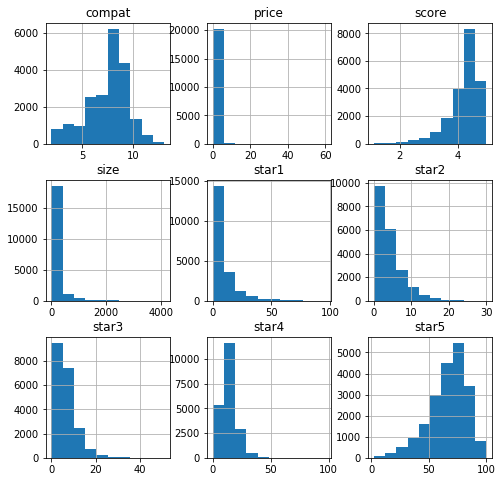

In [12]:
train_set[numeric_feat].hist(bins=10, figsize=(8,8))

To streamline skew correction, a custom transformer is created in conjunction with a data pipeline. The pipeline also implements StandardScalar, which normalizes the features to have a mean of 0 and standard deviation of 1. 

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from scipy.stats import boxcox


class SkewCorrector(BaseEstimator, TransformerMixin):
    
    def __init__(self, skew_bound=0.2): # skew_bound is amount of skew that is acceptable
        self.skew_bound = skew_bound
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_val = X.to_numpy()
        
        # different distributions require different transforms; indicies are defined below for specific data types
        ind_skewed = np.absolute(skew(X_val)) > self.skew_bound
        ind_right_skew = skew(X_val) > 0
        ind_left_skew = skew(X_val) < 0
        ind_no_zeros = [0 not in X_val[:,col] for col in np.arange(X_val.shape[1])]
        ind_has_zeros = [0 in X_val[:,col] for col in np.arange(X_val.shape[1])]
        # if all elements in a feature column are positive, the sum of all those should be equal to the number of rows in that feature matrix
        ind_positive = [np.sign(X_val[:,col]).sum() == X_val.shape[0] for col in np.arange(X_val.shape[1])]

        # transform right and left skewed data that does not include zero values with boxcox
        X_trans, _ = np.apply_along_axis(boxcox, 0, X_val[:,ind_skewed & ind_no_zeros & ind_positive]) # returns list of arrays
        X_val[:,ind_skewed & ind_no_zeros & ind_positive] = np.vstack(X_trans).T
        
        # transform right skewed data that contains zero values with log plus one
        X_trans = np.log1p(X_val[:,ind_skewed & ind_right_skew & ind_has_zeros])
        X_val[:,ind_skewed * ind_right_skew * ind_has_zeros] = X_trans
        
        # transform left skewed data that contains zero values by increasing power incrementally
        for pwr in range(2, 5): #arbitarily set the power limit to 5; maybe make this a user-defined parameter?
            X_trans = X_val[:,ind_skewed * ind_left_skew * ind_has_zeros]**pwr
            if skew(X_trans) < self.skew_bound:
                break
        
        X_val[:,ind_skewed * ind_left_skew * ind_has_zeros] = X_trans
        
        # Update the input data frame with transformed values
        X_out = pd.DataFrame(X_val, index=X.index, columns=X.columns)
        return X_out
        

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])

numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])

Plotting the numeric features after preprocessing indicates that most of the distributions have become approximately normal. Note that *price* is still heavily skewed: almost all games have a price of $0.00.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000006D93F320>,
      dtype=object)

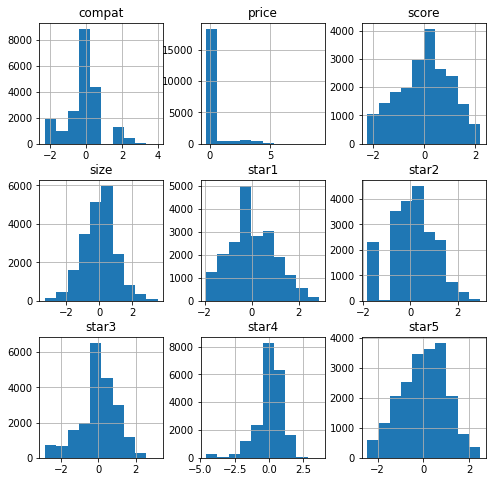

In [15]:
train_set_processed = train_set.copy()

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(8,8))

### Model training and selection <a name='modelselect'></a>


Once the processing pipeline is complete, the training data can now be fitted. A number of different models were tried, mostly using the default hyperparameters. Due to the large outliers, mean absolute error was used in calculating the cross validation scores. 

The following regressors were evaluated: linear regression, elastic net, stochastic gradient descent, linear support vector, k-nearest neighbor, random forest, and gradient tree boosting. 

Prior to cross validation, stratified sampling was used to ensure that the training and validation folds had similiar ratings distributions (in the same way stratified sampling was used to separate the initial data set into training and testing sets). 

In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from functools import partial
    
def init_cv_gen():
    '''Helper function that returns a generator for cross-validation'''
    skf = StratifiedKFold(10, shuffle=True, random_state=42).split(train_set_processed, train_set_binned)
    return skf

def cv_score(estimator):
    '''Generates cross validation scores; used to keep code clean when testing different models (estimator)'''
    cv = init_cv_gen()
    cv_score = cross_val_score(estimator=estimator, X=train_set_processed, y=train_label, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    return cv_score

def show_cv_result(scores):
    '''Print mean and standard deviation of an array of cross validation scores'''
    print(f'Cross validation mean score is : {np.mean(scores)} ± {np.std(scores)}')

In [17]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 9625.729082276986 ± 1092.4114319889306


In [18]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 8432.095107069374 ± 1190.279950225911


In [19]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(loss='huber',max_iter=5000, tol=1e-3)
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 4851.970014813924 ± 1350.7993789061031


In [20]:
from sklearn.svm import LinearSVR

reg = LinearSVR()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 4838.4066777469525 ± 1351.5853284943837


In [21]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 8024.674210477603 ± 1293.9347722438456


Since random forest and gradient tree boosting both rely on decision trees (non-parametric), there is no need to standardize the input data, or correct for skew. 

In [22]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(train_set, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 8237.154023476382 ± 1318.3117935473385


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(loss='huber', random_state=42)
reg.fit(train_set, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 4830.591203630448 ± 1358.657263015344


With the lowest MAE, the best models to optimize further are stochastic gradient descent regression, linear support vector regression, and gradient boosted regression trees.  A grid search was performed to find the optimal hyperparameters. 

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'penalty': ['none', 'elasticnet'],
        'loss': ['huber', 'epsilon_insensitive'],
        'alpha': [1, 0.1, 1e-2, 1e-3, 1e-4],
        'learning_rate': ['invscaling', 'adaptive']
    }
]

reg = SGDRegressor(max_iter=2000, tol=1e-3, early_stopping=True)

sgd_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
sgd_grid.fit(train_set_processed, train_label)
-sgd_grid.best_score_

4843.897499237696

In [25]:
param_grid = [
    {
        'epsilon': [0, .1, 1, 10, 100],
        'C': [1, 10, 100, 1000]
    }
]

reg = LinearSVR(max_iter=10000)

svr_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
svr_grid.fit(train_set_processed, train_label)
-svr_grid.best_score_

4834.7873368431

In [26]:
param_grid = [
    {
        'max_depth': [3, 9],
        'learning_rate': [0.01, 0.1, 1],
        'loss' : ['huber', 'lad']
    }
]

reg = GradientBoostingRegressor(random_state=42)

gbr_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
gbr_grid.fit(train_set, train_label)
-gbr_grid.best_score_

4717.617765740548

With the lowest MAE, the best model to implement is **gradient tree boosting**. For the remainder of the analysis, the model with the optimal hyperparameters as determined by the grid search will be used. 

In [27]:
estimator = gbr_grid.best_estimator_

## Interpreting the regression model results <a name='interpretresults'></a>


Now that a model has been selected and trained, we can assess how reliable and powerful it is, and whether any useful insights may be gained. 

### Model evaluation <a name='evalreg'></a>

The performance of the model on the training and testing sets are compared by mean absolute error and median absolute error. Note that we do not use the processing pipeline prior to inputting the training/testing sets into the model, since the estimator utilizes decision trees (i.e. is non-parametric). 

In [28]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

train_predict = estimator.predict(train_set)
test_predict = estimator.predict(test_set)

# mean absolute error calculation
mae_train = mean_absolute_error(train_label, train_predict)
mae_test = mean_absolute_error(test_label, test_predict)

# median absolute error calculation
medae_train = median_absolute_error(train_label, train_predict)
medae_test = median_absolute_error(test_label, test_predict)

# print results
print(f'Training set mean absolute error and median absolute error is {mae_train} and {medae_train}, respectively')
print(f'Test set mean absolute error and median absolute error is {mae_test} and {medae_test}, respectively')

Training set mean absolute error and median absolute error is 4617.986717385484 and 117.84051815230045, respectively
Test set mean absolute error and median absolute error is 4864.716624022137 and 152.5135322160359, respectively


Testing error is slightly higher compared to the training error (with validation error lying in between), which was anticipated. Note that both mean and median absolute errors were presented given the outliers in this dataset. A small number of games have a number of ratings serveral magnitudes greater than most other apps, leading to a much higher mean absolute error compared to median absolute error. 

### Feature importance  <a name='featimportance'></a>

From a business-perspective, the utility of this model will originate from its ranking of features by importance. Sci-kit's default feature importance metric is based on tree impurity. However, this approach is biased in two ways: it overestimates the importance of high cardinality features, and is calculated based on training set statistics (https://explained.ai/rf-importance/). Consequently, it is preferrable to implement permutation importances, which are based on the test set and are not biased towards high cardinality features (https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html). 

Here, the features are plotted in order of importance. 

Text(0.5, 1.0, 'Permutation Importances (based on test set)')

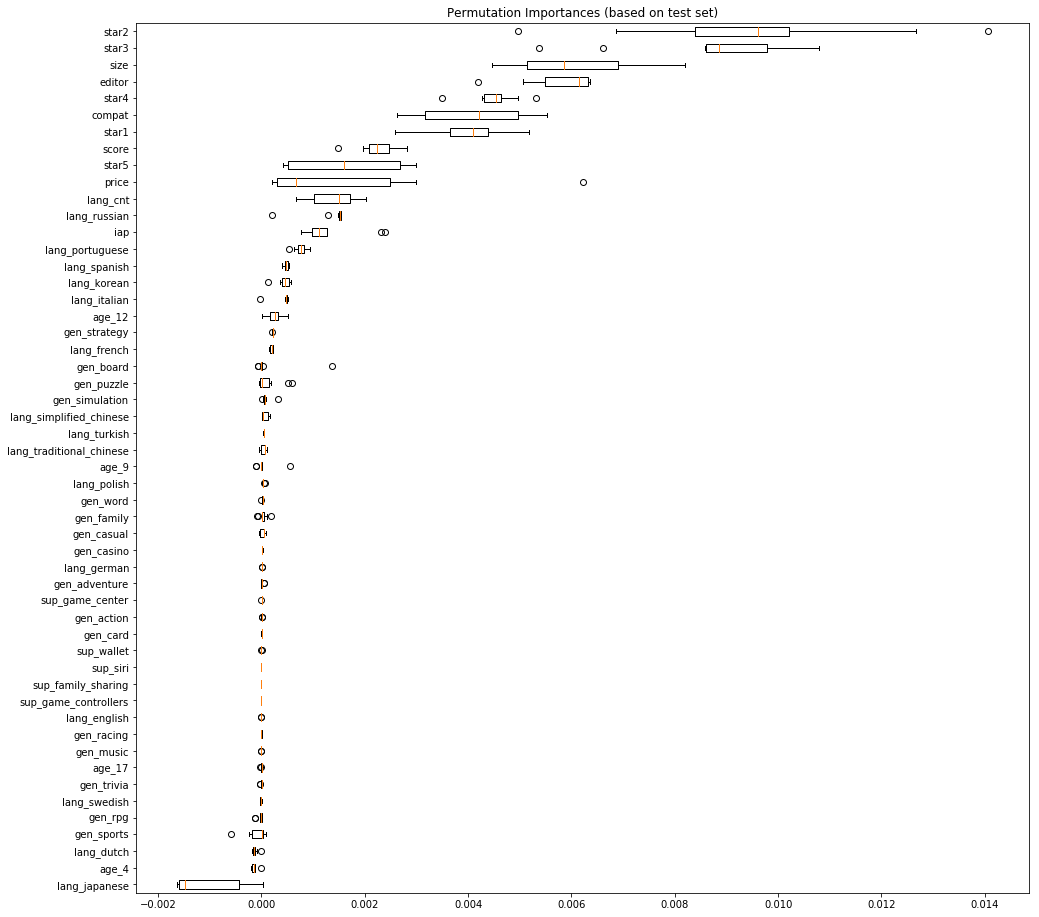

In [29]:
from sklearn.inspection import permutation_importance

result = permutation_importance(estimator, test_set, test_label, n_repeats=10,
                                random_state=42)

# sort to plot in order of importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16,16))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_set.columns[sorted_idx])

ax.set_title("Permutation Importances (based on test set)")

Based on the results above, the following conjectures may be made regarding the non-influential features:


1. **The Chinese market is not particularly influential**. Prior to this project, it was anticipated that opening the game to the Chinese market would substantially increase downloads, due to the popularity of mobile gaming and the population size. However, offering a game in Chinese does not seem to be correlated with the number of ratings. *Note that this conclusion is far from certain. China requires the state approval of apps prior to release. Offering the game in Chinese does not directly imply that the game is neccessarily available in China*. 
2. **Adding additional languages does not seem to influence app popularity**. No particular language seems to be associated with the number of ratings. 
3. **Age ratings are not important**. Games targeted to families are just as successful as games targeted to more mature audiences. 
4. **Genre does not influence game success**. All genres of games are equally likely to be successful. 
5. **iOS app supplementary features are not correlated with app popularity**. Features such as game controller support or Siri connectivity do not infuence the number of ratings. 

The features deemed have some importance require additional analysis. To better illustrate the influence of each feature, the  WSS and four similiar game titles are examined. These games are similiar to WSS in genre, style, and tone. All of these titles are "premium" games, i.e. are not free to play. 

In [30]:
# examples of games to apply model to
examples = ['Where Shadows Slumber', 'Monument Valley',
            'LIMBO', 'Journey', 'Rusty Lake Paradise']

ex = apps[apps['title'].isin(examples)].copy()

# create a DataFrame to quickly compare predicted versus actual number of ratings
ex_summary = ex[['title','author','nrating']].copy()
non_trainable_feat = ['nrating','title','author','nrating_cut','list_rank']
# isolate predictor variables to input in model
ex_feat = ex.drop(columns=non_trainable_feat)
ex_summary['predicted_nrating'] = estimator.predict(ex_feat)

ex_summary

,title,author,nrating,predicted_nrating
97032,Journey,Annapurna Interactive,61.0,185.647939
102552,LIMBO,Playdead,2100.0,2981.833358
117338,Monument Valley,ustwo games,3300.0,4274.849801
148024,Rusty Lake Paradise,Rusty Lake,1100.0,784.839240
187663,Where Shadows Slumber,Game Revenant Ltd,175.0,334.115471


While the model is far from perfect, the estimated number of ratings is reasonable, and actionable insights can be gained. 

Based on the permutation importances analysis, a large number of the features are not predictive of a game's popularity. The top fifteen features are examined by investigating their influence on the five example games. 

### Important numerical features <a name='numfeat'></a>

The most important numerical features are associated with the review score. Other important numerical features include the size of the game (in megabytes MB), and the minimum version compatibility. 

Each feature is examined individually, testing a range of values to determined how the targed variable will respond. It is important to only consider features within a range that the model is properly fitted on, i.e. values where a sufficient amount of training data is available.

Here, only feature values that lie between the 15th and 85th percentile in frequency of occurance will be tested. Feature values that do not occur often (e.g. score <3.0, or size >1000 MB) are *not* tested. Note that analysis of *price* will require a larger range of values to be considered (1-99th percentile), since free games greatly outnumber premium ones. 

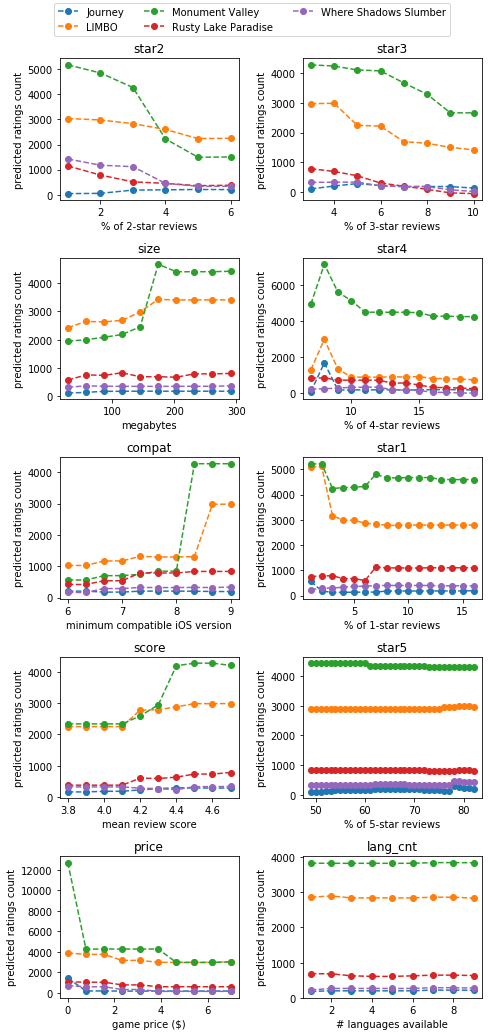

In [31]:
fig, axs = plt.subplots(5,2, figsize=(7, 14))
axs = axs.flatten()

# numerical features to test
star_feats = ['star2', 
              'star3',
              'size',
              'star4',
              'compat',
              'star1',
              'score',
              'star5',
              'price',
              'lang_cnt']

# features of float type (rest are integers)
float_feats = ['size',
               'compat',
               'score',
               'price']

# xlabels to add based on feature being plotted
feats_xlabel = ['% of 2-star reviews',
                '% of 3-star reviews',
                'megabytes',
                '% of 4-star reviews',
                'minimum compatible iOS version',
                '% of 1-star reviews',
                'mean review score',
                '% of 5-star reviews',
                'game price ($)',
                '# languages available']

# loop through each feature and produce a subplot
for feat_ind, feat in enumerate(star_feats):
    
    # isolate predictor variables to input in model
    ex_feat = ex.drop(columns=non_trainable_feat)
    
    # if feature is float type, test a range of values that lie in between the 15th and 85th percentiles 
    # (in terms of frequency of occurance)
    if feat in float_feats: 
        low_bnd = apps[[feat]].quantile(q=0.15, axis=0).item()
        up_bnd = apps[[feat]].quantile(q=0.85, axis=0).item()
        
        # price is heavily skewed; if we consider only titles that lie in the 15-85th percentile range, they would all have a price of $0.00
        # consequently, we will consider all but the most extreme outliers in price
        if feat == 'price':
            low_bnd = apps[[feat]].quantile(q=0.01, axis=0).item()
            up_bnd = apps[[feat]].quantile(q=0.99, axis=0).item()
        
        # for float types, we plot equispaced points between the percentile range described above
        x_rng = np.linspace(low_bnd, up_bnd, num=10)
    
    # if feature is integer type, likewise test values between the 15th and 85th percentile
    # difference from float is that we test all integer values within the prescribed range
    else:
        low_bnd = apps[[feat]].quantile(q=0.15, axis=0).item()
        up_bnd = apps[[feat]].quantile(q=0.85, axis=0).item()
        x_rng = list(range(int(low_bnd), int(up_bnd)))

    # preallocate variable that will contain predicted number of ratings 
    predictions = np.zeros((len(x_rng), len(ex_feat)))

    # calculate predictions for example games
    for ind, val in enumerate(x_rng):
        ex_feat[feat] = val
        predictions[ind,:] = estimator.predict(ex_feat)
    
    # plotting code
    fig.tight_layout()
    axs[feat_ind].plot(x_rng, predictions, linestyle='--', marker='o')
    axs[feat_ind].set_title(feat)
    axs[feat_ind].set_ylabel('predicted ratings count')
    axs[feat_ind].set_xlabel(feats_xlabel[feat_ind])
    
fig.legend(ex_summary['title'].tolist(), 
           loc='upper center', 
           ncol=3,
           bbox_to_anchor=(0.5, 1.03))


Based on the above results, the following conjectures might be made:

1. **Game quality matters the most**. The most important features are the proportion of ratings that are 2 or 3 stars, where a difference of one percentage point is correlated with a substantial increase/decrease in game popularity. Note that the 2 and 3 star ratings percentage is more important than the 1 and 5 star ratings percentages. Analysis of a app reviews suggests that the most thoughtful critical reviewers will assign a score of 2 or 3, whereas 1-star reviews are typically given by customers who misunderstand or are totally incompatible with the product (for example, several 1-star reviews for WSS take issue with the graphic violence in the game, despite its 12+ rating). Larger games are also positively correlated with the number of ratings. Games with greater size are likely to be more complex or contain more content, traits that quality games tend to possess. 
2. **Free games are tied to in-app purchases**. Changing the five example premium games to become free was expected to lead to a substantial increase in the number of ratings. However, this is not apparent in the plot above. This is likely due to the fact that free games almost always include in-app purchases as well. Very few games are free *and* do not have in-app purchases; the model is not well equipped to handle these rare cases. Only Monument Valley offers in-app purchases, which might explain the large drop in predicted number of ratings between free and premium. This will be further explored in the next session. 
3. **Consistent with the previous analysis on non-important features, the number of languages offered by a game is not correlated with the number of ratings**. However, it is emphasized that all five examples are premium; the effect may be there for free games. 

Finally, there is a ratings bump in the 4-star precentage feature at 8% present in Journey, Monument Valley, and LIMBO, that warrants further (separate) investigation.  

### Important categorical features <a name='catfeat'></a>

The categorical features are now investigated. Based on the permutation importances analysis, only three features are in the top fifteen: whether it received an editor's choice award, whether it features Russian, and whether it contains in-app purchases. For the last feature, the price is also changed to \\$0.00. The presence or absence of a categorical feature on the predicted number of ratings is tested on the five example games. 

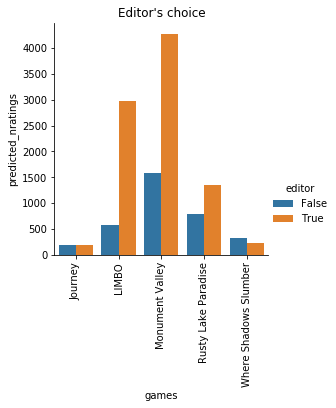

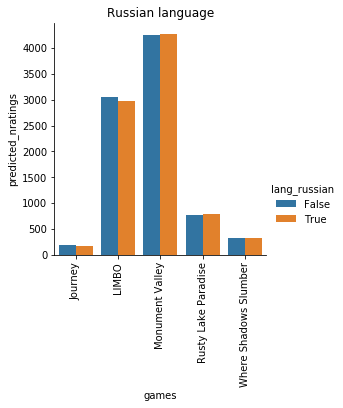

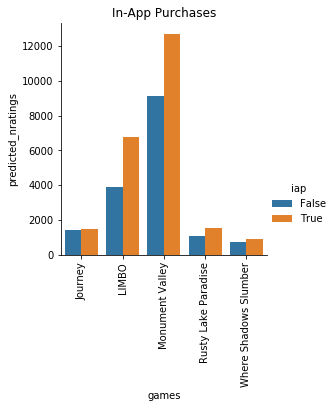

In [32]:
import seaborn as sns

# isolate predictor variables to input in model
bar_data = ex.drop(columns=non_trainable_feat)

# categorical features to test
cat_feat = ['editor', 'lang_russian', 'iap']

# titles for subplots
bar_title = ['Editor\'s choice', 'Russian language', 'In-App Purchases']

# loop through each feature and generate a subplot
for feat, title in zip(cat_feat, bar_title):
    
    # preallocate DataFrame containing predictions
    bar_data_pred = pd.DataFrame()
    
    # set tested feature to false for all example games
    bar_data_false = bar_data.copy()
    bar_data_false[feat] = False
    
    # set tested feature to true for all example games
    bar_data_true = bar_data.copy()
    bar_data_true[feat] = True
    
    # combine 'false' and 'true' versions
    bar_data_pred = bar_data_true.append(bar_data_false)
    
    # almost all games with in-app purchases are free
    # for this specific feature we also change the price to 0.00
    if feat == 'iap':
        bar_data_pred['price'] = 0.00

    # calculate predictions for example games
    bar_data_pred['predicted_nratings'] = estimator.predict(bar_data_pred)
    
    # add game titles to DataFrame (in proper order)
    # note that the list of titles has to be repeated
    # one set for feature set to True, another for the feature set to False
    bar_data_pred['games'] = 2 * ex_summary['title'].tolist()

    # plotting code
    g = sns.catplot(x='games', y='predicted_nratings', hue=feat, 
            data=bar_data_pred, kind='bar', height=4)
    
    plt.title(title)
    g.set_xticklabels(rotation=90)


Based on the above results, the following conjectures might be made:

1. **The editor's choice designation generally leads to increased number of ratings**. This is likely due to the increased advertising the App Store provides for these games. The award is also a reflection of game quality, corroborating the conclusions made after analysis of the important numerical features. 
2. **Free games with in-app purchases lead to more downloads**. All five examples saw an increase in projected number of ratings if the price was changed to \\$0.00, with revenue originating from in-app purchases. 
3. **The presence or absence of Russian is not correlated with increased ratings in premium games**. This corroborates the previous analyses.

## Business strategy recommendations <a name='business'></a>

Prior to this project, the following goals were planned to increase sales of WSS:
1. Create a free version of WSS with in-app purchases (customers would purchases level packs). 
2. Expand into the Chinese market
3. Create a version for Steam (PC gaming). 

### Recommendations <a name='recs'></a>

Based on the results derived from this project, I make the following recommendations: 
1. **Continue development of the free version of WSS**. Virtually all games on the iOS store are free. The mobile gaming market is simply not accustomed to paying for downloads. Successful premium games are likely to have unusually high media attention (e.g. Monument Valley, Limbo), or are ports of already popular games (e.g. Grand Theft Auto). 
2. **Prioritize development of Steam version**. Customers are much more likely to pay for PC games compared to mobile games. Although additional analysis of the Steam market is neccessary to confirm, domain knowledge suggests that WSS will almost certainly be more profitable on PC/Mac.  
3. **Continue improving WSS**. The model suggests that game quality is the most important deciding factor on a game's success, based on the importance of features related to review score. 
4. **Expanding the game to include other countries/languages should be a secondary objective**. The international (i.e. non-English) market does not seem to strongly influence a game's number of ratings. Furthermore, focusing on non-English languages also would require a larger, more expensive marketing campaign. 

Finally, the developer expressed concern about complaints from parents about the level of graphic violence in WSS. Indeed, compared to Monument Valley (a game with which it is frequently compared), WSS has a much darker, mature tone. However, the analysis here suggests that the age rating of a game is not highly correlated with its popularity. 

### Model limitations <a name='limitations'></a>

The largest limitation is that the model assumes that the number of ratings a game receives is strongly correlated with the actual number of downloads. The exact relationship between the ratings count and download count is unknown, and may be a function of game genre, age rating, or language. For example, it is possible that fans of family-friendly puzzle games are more likely to leave a review compared to fans of mature shooting games. Consequently, the financial success of a game may be over/underexaggerated when using the number of reviews as a quality metric. 

The model has limited insight on profitability. The model cannot predict the revennue gain/loss from switching to a "free with in-app purchases" business strategy, since it is unknown how many free game users actually spend money on in-app purchases. Furthermore, there are too few games that are priced >\\$0.00 for the model to accurately predict whether a change in price (e.g. reducing WSS price from \\$2.99 to \\$0.99) would be net profitable. 

Finally, the data for this project was scaped in early October. The feature values shown here may have changed since then. 

### Potential future improvements <a name='future'></a>

Performing an analysis on a game's description via natural language processing (NLP) could yield valuable insights. Incorporating some measure of a game's media coverage would also be useful. 